In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Dataset paths
BASE_DIR = "DIC-C2DH-HeLa"
SEQ = "01"

IMG_DIR = os.path.join(BASE_DIR, SEQ)

In [21]:
def show(img, title=None, cmap="gray"):
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()


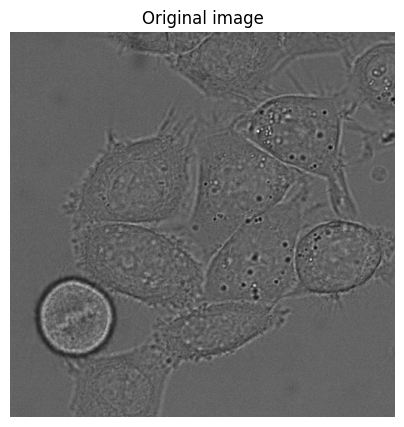

In [35]:
# pick a frame that exists
t = 20
img_path = os.path.join(IMG_DIR, f"t{t:03d}.tif")

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
assert img is not None, "Image not loaded!"

show(img, title="Original image")

In [38]:
import cv2
import numpy as np

img_path = "DIC-C2DH-HeLa/01/t060.tif"
original_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

assert original_gray is not None, "Image not loaded!"

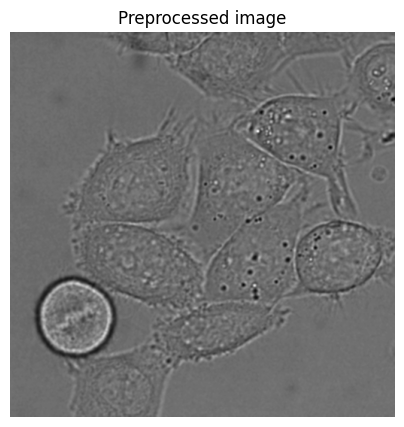

In [39]:
# Gaussian smoothing
blur = cv2.GaussianBlur(img, (5,5), 0)

# Normalize intensity
blur_norm = cv2.normalize(blur, None, 0, 255, cv2.NORM_MINMAX)

show(blur_norm, title="Preprocessed image")

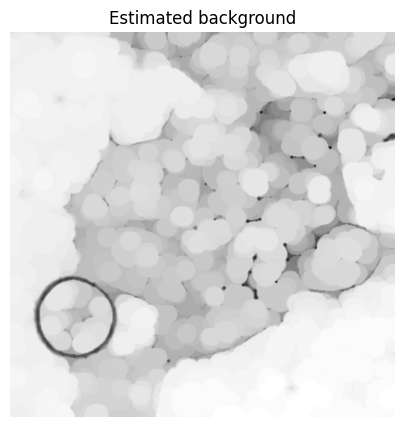

In [40]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25,25))
background = cv2.morphologyEx(blur_norm, cv2.MORPH_OPEN, kernel)

show(background, title="Estimated background")

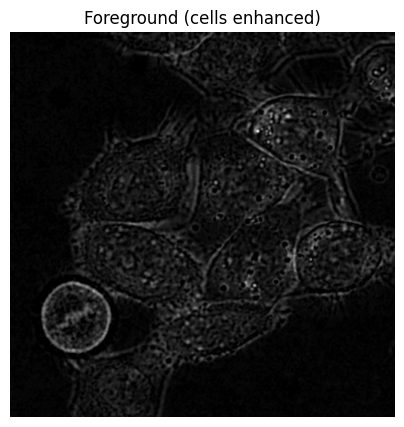

In [41]:
foreground = cv2.subtract(blur_norm, background)
show(foreground, title="Foreground (cells enhanced)")

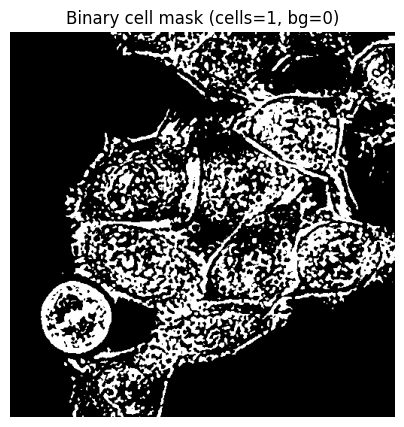

In [42]:
_, cell_mask = cv2.threshold(
    foreground,
    0,
    1,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

show(cell_mask, title="Binary cell mask (cells=1, bg=0)")

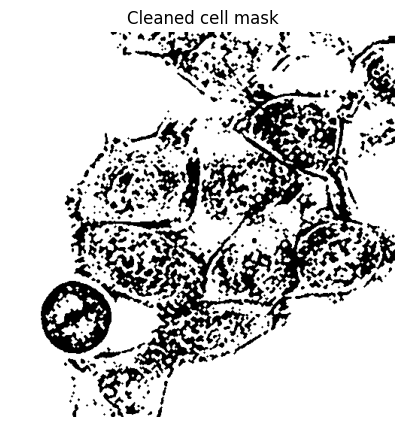

In [43]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
cell_mask_clean = cv2.morphologyEx(cell_mask, cv2.MORPH_OPEN, kernel)
cell_mask_clean = cv2.morphologyEx(cell_mask_clean, cv2.MORPH_CLOSE, kernel)
cell_mask_inv = 1 - cell_mask_clean
show(cell_mask_inv,title="Cleaned cell mask")

In [44]:
import numpy as np
import cv2

def circle_hough_transform(edges, gray, min_r, max_r, vote_thresh):
    h, w = edges.shape

    # Gradient from original grayscale image (IMPORTANT)
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    theta = np.arctan2(gy, gx)

    circles = []
    edge_points = np.argwhere(edges > 0)

    for r in range(min_r, max_r + 1):
        acc = np.zeros((h, w), dtype=np.uint16)

        for (y, x) in edge_points:
            angle = theta[y, x]

            a = int(x - r * np.cos(angle))
            b = int(y - r * np.sin(angle))

            if 0 <= a < w and 0 <= b < h:
                acc[b, a] += 1

        ys, xs = np.where(acc >= vote_thresh)
        for cy, cx in zip(ys, xs):
            circles.append((cx, cy, r, acc[cy, cx]))

    return circles

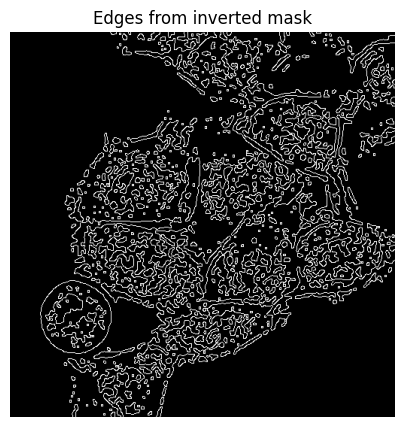

Detected circles: 0
No circles detected.


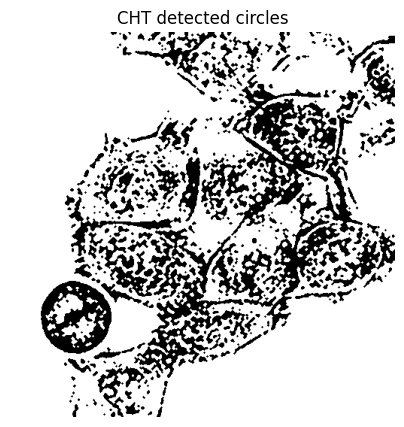

In [45]:
mask_u8 = (cell_mask_inv * 255).astype(np.uint8)

edges = cv2.Canny(mask_u8, 50, 150)
show(edges, title="Edges from inverted mask")

circles = circle_hough_transform(
    edges=edges,
    gray=original_gray,   # <-- THIS MUST EXIST
    min_r=5,
    max_r=50,
    vote_thresh=15
)

print("Detected circles:", len(circles))
vis = cv2.cvtColor(mask_u8, cv2.COLOR_GRAY2BGR)

if len(circles) == 0:
    print("No circles detected.")
else:
    for (x, y, r, votes) in circles:
        cv2.circle(vis, (x, y), r, (0, 255, 0), 2)
        cv2.circle(vis, (x, y), 2, (0, 0, 255), -1)

show(vis, title="CHT detected circles")

In [31]:
print("Number of detected circles:", len(circles))

Number of detected circles: 0
